## Import Libraries

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import glob
import librosa
import librosa.display as ld
# Printa todos os valores do array
#np.set_printoptions(threshold=np.inf)
np.set_printoptions(threshold=10)
import pandas as pd
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
import os
import re
from sklearn.externals import joblib

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv1D
from keras import backend as K

#### To load records

In [2]:
#data = glob.glob('1seg/test/*.mp3')
#data = glob.glob('2seg/fold1/*.mp3')
#data = glob.glob('../../Projeto_phd/academia/*.wav')
data_casa = glob.glob('casa/*.wav')
data_academia = glob.glob('academia/*.wav')
#data_faculdade = glob.glob('faculdade/*.wav')
#print ((data_casa))

In [3]:
def load_datas(data):
    len_audios = []
    audios = []

    for file in sorted(data):
        audio, sr = librosa.core.load(file, sr=None, mono=True, offset=0.0, duration=None)
        len_audios.append(len(audio))
        audios.append(audio)
        max_audio = max(len_audios)
        
    return audios, max(len_audios), sr

def spectrograms(audios, len_audios, sr):
    
    hop_length = 400
    n_fft = 500

    #To convert the hop length and frame size to units of seconds:
    #print ("hop length[s]:", float(hop_length)/sr) # units of seconds
    #print ("frame size[s]:",float(n_fft)/sr) # units of seconds

    audios_resize = []
    specs = []

    for i in range(len(audios)):
        shape = (len_audios)
        i_audio = np.array(audios[i])
        i_audio.resize(shape)
        x = librosa.stft(i_audio, n_fft=n_fft, hop_length=hop_length)
        X = librosa.amplitude_to_db(np.abs(x), ref=np.max)
        specs.append(X)
        audios_resize.append(i_audio)
        
    return specs

In [4]:
audios_a, len_audios_a, sr = load_datas(data_academia)
audios_c, len_audios_c, sr = load_datas(data_casa)
#audios_f, len_audios_f, sr = load_datas(data_faculdade)

print(len_audios_a, len_audios_c)

def spectro_length(audio1, len1, audio2, len2, sr):
    
    if len1 > len2:
        specs1 = spectrograms(audio1, len1, sr)
        specs2 = spectrograms(audio2, len1, sr)
    else:
        specs1 = spectrograms(audio1, len2, sr)
        specs2 = spectrograms(audio2, len2, sr)
    return specs1, specs2

specs_a, specs_c = spectro_length(audios_a, len_audios_a, audios_c, len_audios_c, sr)

print (specs_a[0].shape)
print (specs_c[0].shape)

67356 56905
(251, 169)
(251, 169)


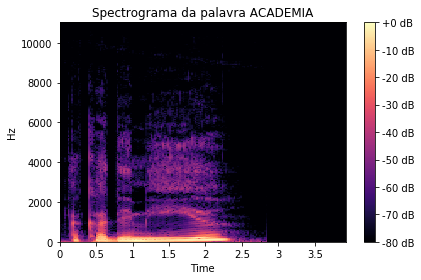

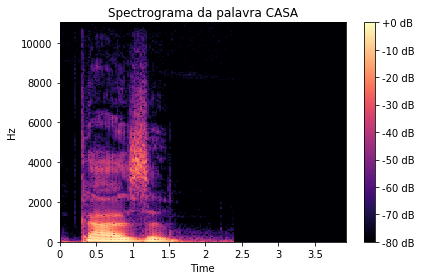

In [52]:
ld.specshow(specs_a[0],y_axis='linear', x_axis='time')
plt.title('Spectrograma da palavra ACADEMIA')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

ld.specshow(specs_c[0],y_axis='linear', x_axis='time')
plt.title('Spectrograma da palavra CASA')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

#### To load Labels

In [5]:
def labeling(pathname):
    l = []
    for file in pathname:
        (dirname, sname) = os.path.split(file)
        (name, ext) = os.path.splitext(sname)
        #print (name)
        n = re.split('[0-9]+', name, flags=re.IGNORECASE)
        l.append([n[0]])
    return l

#l_casa = np.array(labeling(data_casa))
l_casa = labeling(data_casa)
l_academia = labeling(data_academia)

#type(l_casa)

## To separate 80% to train and 20% to test

In [12]:
#stratify: certifica a mesma quantidade de audios de cada classe.

def holdout2dataset(data1, l1, data2, l2):
    
    x_train, x_test1, y_train, y_test1 = train_test_split(data1, l1, test_size=0.5, random_state=42, stratify=l1)
    x_test, x_val, y_test, y_val = train_test_split(x_test1, y_test1, test_size=0.5, random_state=42, stratify=y_test1)
    
    X_train, X_test1, Y_train, Y_test1 = train_test_split(data2, l2, test_size=0.5, random_state=42, stratify=l2)
    X_test, X_val, Y_test, Y_val = train_test_split(X_test1, Y_test1, test_size=0.5, random_state=42, stratify=Y_test1)
    
    #x_tr = np.concatenate(x_train, X_train)
    #x_v = np.concatenate(x_val, X_val)
    #x_te = np.concatenate(x_test, X_test)
    
    x_tr = x_train + X_train
    x_v = x_val + X_val
    x_te = x_test + X_test
    
    y_tr = y_train + Y_train
    y_v = y_val + Y_val
    y_te = y_test + Y_test
    
    return x_tr, x_v, x_te, y_tr, y_v, y_te

#x_train, x_val, x_test, y_train, y_val, y_test = holdout(specs_a, l_academia, specs_c, l_casa)
#Verificação das variáveis.

#len(x_train), len(x_val), len(x_test), len(y_train), len(y_val), len(y_test)
#c = a = 0
#for i in range(len(y_train)):
 #   if y_train[i] == ["academia"]:
 #       a = a+1
 #   else:
 #       c = c+1
        
#print (a, c)

#x_train = np.array(x_train)
#x_val = np.array(x_val)
#x_test = np.array(x_test)

#y_train = np.array(y_train)
#y_val = np.array(y_val)
#y_test = np.array(y_test)
    
   

In [53]:
x_train_c, x_test_c1, y_train_c, y_test_c1 = train_test_split(specs_c, l_casa, test_size=0.5, random_state=42, stratify=l_casa)
x_test_c, x_val_c, y_test_c, y_val_c = train_test_split(x_test_c1, y_test_c1, test_size=0.5, random_state=42, stratify=y_test_c1)

x_train_a, x_test_a1, y_train_a, y_test_a1 = train_test_split(specs_a, l_academia, test_size=0.5, random_state=42, stratify=l_academia)
x_test_a, x_val_a, y_test_a, y_val_a = train_test_split(x_test_a1, y_test_a1, test_size=0.5, random_state=42, stratify=y_test_a1)


In [60]:
x_train_a = np.array(x_train_a)
x_val_a = np.array(x_val_a)
x_test_a = np.array(x_test_a)
y_train_a = np.array(y_train_a)
y_val_a = np.array(y_val_a)
y_test_a = np.array(y_test_a)

x_train_c = np.array(x_train_c)
x_val_c = np.array(x_val_c)
x_test_c = np.array(x_test_c)
y_train_c = np.array(y_train_c)
y_val_c = np.array(y_val_c)
y_test_c = np.array(y_test_c)

#x_train_c.shape
#len(x_train_a), len(x_val_a), len(x_test_a)

In [ ]:
#Para armazenar as variáveis e rodar em outro programa.
#joblib.dump(x_train_np, "features_propaganda/2segs/x_train.pkl")
#joblib.dump(x_test_np, "features_propaganda/2segs/x_test.pkl")
#joblib.dump(x_val_np, "features_propaganda/2segs/x_val.pkl")
#joblib.dump(y_train_np, "features_propaganda/2segs/y_train.pkl")
#joblib.dump(y_test_np, "features_propaganda/2segs/y_test.pkl")
#joblib.dump(y_val_np, "features_propaganda/2segs/y_val.pkl")


### Aplicação da CNN siamesa

In [50]:
def CNN_Architecture(x_train_np, x_val_np, x_test_np, y_train_np, y_val_np, y_test_np):
    batch_size = 20
    epochs = 50
    
    # input image dimensions
    img_rows = x_train_np.shape[1]
    img_cols = x_train_np.shape[2]

    if K.image_data_format() == 'channels_first':
        x_train_np = x_train_np.reshape(x_train_np.shape[0], 1, img_rows, img_cols)
        x_val_np = x_val_np.reshape(x_val_np.shape[0], 1, img_rows, img_cols)
        x_test_np = x_test_np.reshape(x_test_np.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train_np = x_train_np.reshape(x_train_np.shape[0], img_rows, img_cols, 1)
        x_val_np = x_val_np.reshape(x_val_np.shape[0], img_rows, img_cols, 1)
        x_test_np = x_test_np.reshape(x_test_np.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train_np = x_train_np.astype('float32')
    x_val_np = x_val_np.astype('float32')
    x_test_np = x_test_np.astype('float32')
    x_train_np /= 255
    x_val_np /= 255
    x_test_np /= 255
    
    #print('x_train shape:', x_train_np.shape)
    #print(x_train_np.shape[0], 'train samples')
    #print(x_val_np.shape[0], 'val samples')
    #print(x_test_np.shape[0], 'test samples')
    #print (input_shape)

    #print ('y_train shape:', y_train_np.shape)

    num_classes = 2
    #y_train_np = keras.utils.to_categorical(y_train_bi, num_classes)
    #y_test_np = keras.utils.to_categorical(y_test_bi, num_classes)
    #y_val_np = keras.utils.to_categorical(y_val_bi, num_classes)

    #print ('y_train shape:', y_train_np.shape)

    model = Sequential()
    # Input Layer
    input_shape=input_shape
    # Hidden Layer
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu')) #200
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    return model

In [61]:
model_A = CNN_Architecture(x_train_a, x_val_a, x_test_a, y_train_a, y_val_a, y_test_a)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 249, 167, 16)      160       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 124, 83, 16)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 122, 81, 16)       2320      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 61, 40, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 59, 38, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 29, 19, 16)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 8816)              0         
__________

In [62]:
model_C = CNN_Architecture(x_train_c, x_val_c, x_test_c, y_train_c, y_val_c, y_test_c)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 249, 167, 16)      160       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 124, 83, 16)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 122, 81, 16)       2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 61, 40, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 59, 38, 16)        2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 29, 19, 16)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8816)              0         
__________

## Referências

- https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
- https://github.com/hlamba28/One-Shot-Learning-with-Siamese-Networks/blob/master/Siamese%20on%20Omniglot%20Dataset.ipynb